In [1]:
import torch
import torch.nn as nn
import torchtext
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import ast
import time
from others.config import *

hyperparameters = config['hyperparameters']
gpu = ('cuda:0')

In [2]:
df = pd.read_csv('dataset/preprocessed_dataset.csv')
df.head()

,labels,preprocessed_docs
0,0,go jurong point crazi avail bugi n great world...
1,0,ok lar joke wif u oni
2,1,free entri wkli comp win fa cup final tkt st m...
3,0,u dun say earli hor u c alreadi say
4,0,nah think goe usf live around though


In [3]:
df.tail()

,labels,preprocessed_docs
5561,1,nd time tri contact u u pound prize claim easi...
5562,0,b go esplanad fr home
5563,0,piti mood soani suggest
5564,0,guy bitch act like would interest buy someth e...
5565,0,rofl true name


In [4]:
print(f'Null Data: \n{df.isnull().sum()}\n')
print('Empty Cell: \n{}'.format(df[df['preprocessed_docs'] == ''].index))

Null Data: 
labels               0
preprocessed_docs    0
dtype: int64

Empty Cell: 
Int64Index([], dtype='int64')


In [5]:
print(len(df))

5566


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

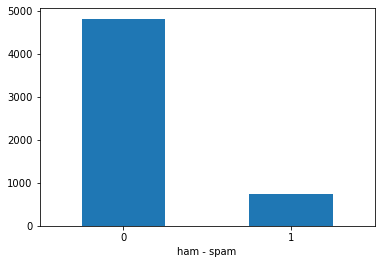

In [6]:
df['labels'].value_counts().plot(kind='bar')
plt.xlabel('ham - spam')
plt.xticks(rotation=0) 

In [7]:
TEXT = torchtext.data.Field(
    sequential=True
    ,batch_first=True
    ,lower=True
    ,tokenize='spacy'
    ,pad_first=True
    )

LABEL = torchtext.data.Field(
    sequential=False
    ,use_vocab=False
    ,is_target=True
    )

In [8]:
dataset = torchtext.data.TabularDataset(
    path='dataset/preprocessed_dataset.csv',
    format='csv',
    skip_header=True,
    fields=[
        ('label', LABEL), 
        ('data', TEXT)
        ]
    )

In [9]:
print(dataset[0].data)
print(dataset[0].label)

['go', 'jurong', 'point', 'crazi', 'avail', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amor', 'wat']
0


In [10]:
train_dataset, valid_dataset = dataset.split(split_ratio=0.7, random_state = random.seed(14)) 

In [11]:
TEXT.build_vocab(train_dataset)
vocab = TEXT.vocab
print('len vocab: {}'.format(len(vocab)))
# vocab.stoi

len vocab: 5875


In [12]:
train_iter, valid_iter = torchtext.data.BucketIterator.splits(
    (train_dataset, valid_dataset), 
    sort_key=lambda x: len(x.data),
    batch_sizes=(ast.literal_eval(hyperparameters['batch_sizes'])[0], ast.literal_eval(hyperparameters['batch_sizes'])[1]), 
    device=gpu
    )

In [13]:
for inputs, labels in train_iter:
    print('inputs: {}, shape: {}'.format(inputs, inputs.shape))
    print('lables: {}, shape: {}'.format(labels, labels.shape))
    break

inputs: tensor([[   1,    1,    1,  ...,  113,  110, 3628],
        [   1,    1,    1,  ...,   69,   13,  555],
        [   1,    1,    1,  ...,  121,   16,  334],
        ...,
        [   1,    1,    1,  ...,  580, 1205,   95],
        [   1,    1,    1,  ...,  150,   46, 1938],
        [   1,    1,    1,  ...,   47, 1365, 3161]], device='cuda:0'), shape: torch.Size([64, 43])
lables: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), shape: torch.Size([64])


In [14]:
for inputs, labels in valid_iter:
    print('inputs: {}, shape: {}'.format(inputs, inputs.shape))
    print('lables: {}, shape: {}'.format(labels, labels.shape))
    break

inputs: tensor([[ 926, 1362],
        [   2, 1016],
        [ 210,   77],
        [   0,    5],
        [ 185,   86],
        [2509, 1398],
        [   0,  372],
        [   2,  176],
        [  11,   86],
        [  71,  231],
        [ 126,  227],
        [   0, 1964],
        [ 735, 2389],
        [3599,  225],
        [   0,    0],
        [  84,    0],
        [  11,  323],
        [   0,    0],
        [ 395, 3457],
        [  28,    0],
        [   0,   18],
        [  36,   50],
        [  65,    4],
        [  10,  987],
        [2425, 2384],
        [ 523,  148],
        [ 302,   15],
        [  66,   77],
        [ 304, 3457],
        [  99,  196],
        [ 511,   86],
        [ 317, 1582],
        [   8, 1146],
        [  57,   49],
        [   0,  613],
        [ 391,    0],
        [  55, 2470],
        [ 139, 5251],
        [ 185,  173],
        [ 102,  229],
        [ 791,  279],
        [4441,  419],
        [  17,  195],
        [   5,  202],
        [   4, 1611],
  

In [15]:
batch_train = next(iter(train_iter))
doc_train, label_train = batch_train
batch_test = next(iter(valid_iter))
doc_test, label_test = batch_test

def itos_(iterator):
    docs_ = []
    for i in range (len(iterator)):
        x = iterator[i].item()
        doc = str(TEXT.vocab.itos[x])
        docs_.append(doc)
    docs = ' '.join(docs_)
    return docs, docs_

In [16]:
print(itos_(doc_train[27])[0])
print('label: {}'.format(label_train[27]))

<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> nd time tri contact u u pound prize claim easi call p per minut btnationalr
label: 1


In [17]:
class LSTM(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_layers, n_outputs):
        super(LSTM, self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.M = n_hidden
        self.L = n_layers
        self.K = n_outputs
        
        self.embed = nn.Embedding(
            self.V, 
            self.D
            )
        self.lstm = nn.LSTM(
            input_size = self.D,
            hidden_size = self.M,
            num_layers = self.L,
            batch_first = True
            )
        self.fc = nn.Linear(
            self.M, 
            self.K
            )
    
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(gpu)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(gpu)
        
        out = self.embed(X)

        out, _ = self.lstm(out, (h0, c0))

        out, _ = torch.max(out, 1)

        out = self.fc(out)

        return out

In [18]:
torch.manual_seed(14)
model = LSTM(
    len(vocab),
    ast.literal_eval(hyperparameters['embed_dims']), 
    ast.literal_eval(hyperparameters['num_lstm_units']), 
    ast.literal_eval(hyperparameters['num_lstm_layers']), 
    ast.literal_eval(hyperparameters['num_output_classes'])
    ).to(gpu)
model

LSTM(
  (embed): Embedding(5875, 512)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [19]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr = ast.literal_eval(hyperparameters['learning_rate'])
    )

In [20]:
import sys
num_epochs = ast.literal_eval(hyperparameters['num_epochs'])
losses = []
accuracies  = []
val_losses = []
val_accuracies = []
val_loss_min = np.inf

for epoch in range(num_epochs):
    print('------------------------------------------------------------------------------------------')
    print('epoch: {}/{}:'.format(epoch + 1, num_epochs))   
    print('------------------------------------------------------------------------------------------')
    t0 = time.time()

    train_tqdm_bar = tqdm(enumerate(train_iter), total = (len(train_iter)), leave = False, position = 0, file = sys.stdout, dynamic_ncols = True)
    val_tqdm_bar = tqdm(enumerate(valid_iter), total = (len(valid_iter)),  leave = False, position = 0, file = sys.stdout, dynamic_ncols = True)
 
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    model.train()
    for idx, (inputs, labels) in train_tqdm_bar:
        labels = labels.view(-1, 1).float()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), max_norm = 1)
        optimizer.step()
        running_loss += loss
        preds = torch.round(torch.sigmoid(outputs))
        running_corrects += torch.sum(preds == labels)
        train_tqdm_bar.set_description(desc = 'train   '.format(epoch + 1, num_epochs))
        batch_idx = (idx + 1) * ast.literal_eval(hyperparameters['batch_sizes'])[0]
        train_tqdm_bar.set_postfix(
            loss = running_loss.item() / batch_idx if idx + 1 < len(train_iter) else running_loss.item() / len(train_iter.dataset)
            ,acc = running_corrects.item() / batch_idx if idx + 1 < len(train_iter) else running_corrects.item() / len(train_iter.dataset)
            )
    
    model.eval()
    with torch.no_grad():
        for val_idx, (val_inputs, val_labels) in val_tqdm_bar:
            val_labels = val_labels.view(-1, 1).float()
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss
            val_preds = torch.round(torch.sigmoid(val_outputs))
            val_running_corrects += torch.sum(val_preds == val_labels)
            val_tqdm_bar.set_description('validate'.format(epoch + 1, num_epochs))
            val_batch_idx = (val_idx + 1) * ast.literal_eval(hyperparameters['batch_sizes'])[1]
            val_tqdm_bar.set_postfix(
            val_loss = val_running_loss.item() / val_batch_idx if val_idx + 1 < len(valid_iter) else val_running_loss.item() / len(valid_iter.dataset)
            ,val_acc = val_running_corrects.item() / val_batch_idx if val_idx + 1 < len(valid_iter) else val_running_corrects.item() / len(valid_iter.dataset)
            )

    epoch_loss = running_loss/len(train_iter.dataset)
    losses.append(epoch_loss)
    epoch_accuracy = running_corrects/len(train_iter.dataset)
    accuracies.append(epoch_accuracy)
    val_epoch_loss = val_running_loss/len(valid_iter.dataset)
    val_losses.append(val_epoch_loss)
    val_epoch_accuracy = val_running_corrects/len(valid_iter.dataset)
    val_accuracies.append(val_epoch_accuracy)

    checkpoint = {
            'epoch': epoch + 1
            ,'state_dict': model.state_dict()
            ,'optimizer' : optimizer.state_dict()
            ,'val_loss_min' : val_epoch_loss
        }
    
    # saving model every epoch
    # torch.save(checkpoint, r'checkpoint\spam_ham_epoch_{}.pth'.format(epoch + 1))

    print('training loss: {:.4f}, acc: {:.2f}'.format(epoch_loss, epoch_accuracy))
    print('validation loss: {:.4f}, acc: {:.2f}'.format(val_epoch_loss, val_epoch_accuracy))
    print('epoch time: {:.2f} seconds'.format(time.time() - t0))
    
    if val_epoch_loss <= val_loss_min:
        print('validation loss decreased from {:.4f} to {:.4f}, saving model...'.format(val_loss_min, val_epoch_loss))
        torch.save(checkpoint, r'D:\\Data\\Documents\\Rafi\\Python Scripts\\Spam_Classifier_LSTM_PyTorch\\checkpoint\\spam_ham_lowest_val_loss_epoch_{}.pth'.format(epoch + 1))
        val_loss_min = val_epoch_loss

------------------------------------------------------------------------------------------
epoch: 1/20:
------------------------------------------------------------------------------------------
training loss: 0.0065, acc: 0.85
validation loss: 0.0032, acc: 0.87
epoch time: 5.30 seconds
validation loss decreased from inf to 0.0032, saving model...
------------------------------------------------------------------------------------------
epoch: 2/20:
------------------------------------------------------------------------------------------
training loss: 0.0055, acc: 0.87
validation loss: 0.0011, acc: 0.96
epoch time: 4.93 seconds
validation loss decreased from 0.0032 to 0.0011, saving model...
------------------------------------------------------------------------------------------
epoch: 3/20:
------------------------------------------------------------------------------------------
training loss: 0.0014, acc: 0.97
validation loss: 0.0005, acc: 0.98
epoch time: 4.84 seconds
validatio

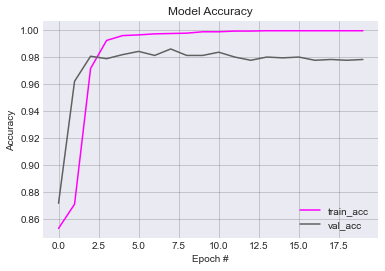

In [21]:
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(accuracies, color = 'magenta')
plt.plot(val_accuracies, color = '#606060')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.legend(['train_acc', 'val_acc'], loc = 'lower right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)
# plt.savefig(r'graphs\acc_lstm.png', dpi = 100)

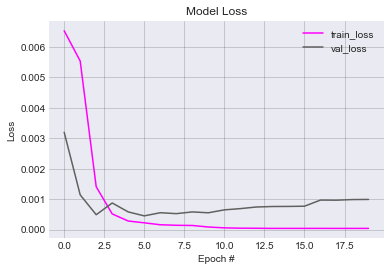

In [22]:
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(losses, color = 'magenta')
plt.plot(val_losses, color = '#606060')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(['train_loss', 'val_loss'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)
# plt.savefig(r'graphs\loss_lstm.png', dpi = 100)

In [23]:
# torch.save(model.state_dict(), r'model\spam_ham.pth')